In [2]:
import os
# Change native directory to root
os.chdir(os.path.dirname(os.getcwd()))

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from joblib import dump
from scipy.stats import norm, multivariate_normal
import lightgbm as lgb
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import pickle as pkl
import joblib as joblib
target = 'net_target+1'

In [4]:
data_train = pd.read_csv('data/extra_train.csv')
data_train

,Unnamed: 0,Month,Hour,cons_target,Solar Generation [W/kW],Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],day_year,...,net_target,net+1,net-23,net_target+1,net_target-23,net_target_diff,diffuse_solar_radiation+1,direct_solar_radiation+1,relative_humidity+1,drybulb_temp+1
0,0,8,0,0.441346,0.000000,19.4,81.0,0.000000,0.000000,23,...,0.617429,1.411333,2.275800,0.431845,0.506612,-0.029331,0.000000,0.000000,81.0,20.0
1,1,8,1,0.170776,0.000000,20.0,81.0,0.000000,0.000000,24,...,0.431845,0.979417,0.851167,0.394489,0.383397,-0.185584,0.000000,0.000000,87.0,19.4
2,2,8,2,0.116313,0.000000,19.4,87.0,0.000000,0.000000,25,...,0.394489,0.900975,0.834600,0.387705,0.381964,-0.037356,0.000000,0.000000,87.0,19.4
3,3,8,3,0.106422,0.000000,19.4,87.0,0.000000,0.000000,26,...,0.387705,0.922433,0.838167,0.389561,0.382273,-0.006784,0.000000,0.000000,90.0,19.4
4,4,8,4,0.109127,0.000000,19.4,90.0,0.000000,0.000000,27,...,0.389561,0.910483,1.478433,0.388527,0.437649,0.001856,0.000000,0.000000,90.0,18.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43675,43675,7,19,0.802751,31.179167,21.1,81.0,5.389072,5.669881,8754,...,0.862123,2.713900,3.463783,0.720845,0.814933,0.090374,3.295837,4.875197,84.0,20.6
43676,43676,7,20,0.552807,4.070833,20.6,84.0,3.295837,4.875197,8755,...,0.720845,0.935833,0.457167,0.497751,0.437693,-0.141277,0.000000,0.000000,81.0,21.1
43677,43677,7,21,0.189487,0.000000,21.1,81.0,0.000000,0.000000,8756,...,0.497751,2.155017,0.714717,0.650722,0.470007,-0.223094,0.000000,0.000000,79.0,21.7
43678,43678,7,22,0.436347,0.000000,21.7,79.0,0.000000,0.000000,8757,...,0.650722,2.316400,1.659000,0.670971,0.588487,0.152971,0.000000,0.000000,76.0,21.3


In [5]:
model_pt = joblib.load('models/point/lgb_next_step_diff_12march.pkl')
features = model_pt.feature_name()
preds = model_pt.predict(data_train[features])
data_train['preds'] = preds

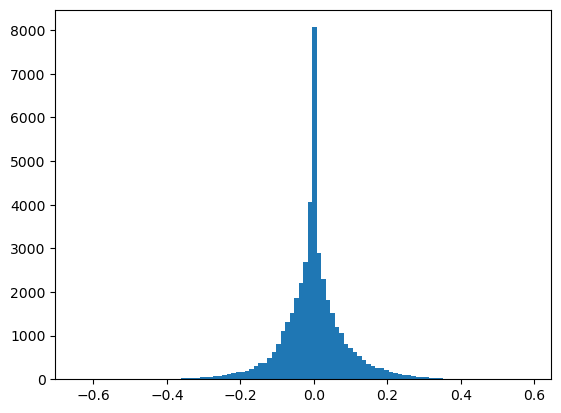

In [6]:
data_train['residual'] = data_train['net_target+1'] - data_train['net_target']
# plot distribution of residuals
plt.hist(data_train['residual'], bins=100)
plt.show()

In [9]:
# maka a dataframe with lead times and the corresponding residual
lead_times = ['residual+'+str(i) for i in range(1, 25)]
residuals = pd.DataFrame(columns=lead_times)
for build in data_train['number'].unique():
    data_train_build = data_train.loc[data_train['number'] == build]
    residuals_build = pd.DataFrame(columns=lead_times, index=data_train_build.index)
    residuals_build['time_step'] = data_train_build['day_year'].values
    # reverse the shift in the data preparation
    residuals_build['Hour'] = data_train_build['Hour'].shift(1).values 
    residuals_build['Month'] = data_train_build['Month'].values
    residuals_build['building'] = data_train_build['number'].values
    residuals_build['residual'] = data_train_build['residual'].values
    for i, lead_time in enumerate(lead_times):
        residuals_build[lead_time] = data_train_build['residual'].shift(-int(i+1))
    # use pdconcat to append the dataframes
    residuals = pd.concat([residuals, residuals_build], axis=0)
# put last 5 columns to the front
cols = residuals.columns.tolist()
cols = cols[-5:] + cols[:-5]
# drop the rows with NaN
residuals = residuals.dropna()
residuals = residuals[cols]

In [10]:
residuals

,time_step,Hour,Month,building,residual,residual+1,residual+2,residual+3,residual+4,residual+5,...,residual+15,residual+16,residual+17,residual+18,residual+19,residual+20,residual+21,residual+22,residual+23,residual+24
1,24.0,0.0,8.0,1.0,-0.037356,-0.006784,0.001856,-0.001034,0.008633,0.019979,...,0.043818,0.249512,0.013351,0.269281,-0.003759,-0.109067,-0.176181,-0.046832,0.037803,-0.071450
2,25.0,1.0,8.0,1.0,-0.006784,0.001856,-0.001034,0.008633,0.019979,-0.042165,...,0.249512,0.013351,0.269281,-0.003759,-0.109067,-0.176181,-0.046832,0.037803,-0.071450,0.000471
3,26.0,2.0,8.0,1.0,0.001856,-0.001034,0.008633,0.019979,-0.042165,-0.052587,...,0.013351,0.269281,-0.003759,-0.109067,-0.176181,-0.046832,0.037803,-0.071450,0.000471,0.000887
4,27.0,3.0,8.0,1.0,-0.001034,0.008633,0.019979,-0.042165,-0.052587,-0.073572,...,0.269281,-0.003759,-0.109067,-0.176181,-0.046832,0.037803,-0.071450,0.000471,0.000887,-0.000549
5,28.0,4.0,8.0,1.0,0.008633,0.019979,-0.042165,-0.052587,-0.073572,-0.086799,...,-0.003759,-0.109067,-0.176181,-0.046832,0.037803,-0.071450,0.000471,0.000887,-0.000549,0.038502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43651,8730.0,18.0,7.0,5.0,0.002683,-0.377241,0.032315,0.118479,-0.069741,0.030167,...,0.119318,-0.006669,0.119979,-0.039573,0.047844,0.081232,0.061972,0.182693,0.090374,-0.141277
43652,8731.0,19.0,7.0,5.0,-0.377241,0.032315,0.118479,-0.069741,0.030167,-0.043724,...,-0.006669,0.119979,-0.039573,0.047844,0.081232,0.061972,0.182693,0.090374,-0.141277,-0.223094
43653,8732.0,20.0,7.0,5.0,0.032315,0.118479,-0.069741,0.030167,-0.043724,-0.005531,...,0.119979,-0.039573,0.047844,0.081232,0.061972,0.182693,0.090374,-0.141277,-0.223094,0.152971
43654,8733.0,21.0,7.0,5.0,0.118479,-0.069741,0.030167,-0.043724,-0.005531,-0.042938,...,-0.039573,0.047844,0.081232,0.061972,0.182693,0.090374,-0.141277,-0.223094,0.152971,0.020249


In [11]:
residuals.iloc[:, 5:].mean()

residual+1     1.342307e-05
residual+2     2.107784e-06
residual+3     6.737006e-06
residual+4    -1.814019e-07
residual+5     3.987028e-06
residual+6     2.223380e-06
residual+7     1.852899e-07
residual+8     3.506987e-06
residual+9     1.508874e-06
residual+10    2.570466e-06
residual+11    1.619859e-06
residual+12    6.100174e-07
residual+13    9.893776e-06
residual+14   -2.269601e-06
residual+15    1.609942e-06
residual+16    9.066262e-07
residual+17   -8.961706e-06
residual+18   -2.577658e-06
residual+19    1.804056e-06
residual+20    8.294743e-06
residual+21   -2.345269e-06
residual+22    9.776163e-06
residual+23    1.646895e-05
residual+24    1.389945e-05
dtype: float64

In [13]:
# find a correlation matrix between lead times
corr = residuals.iloc[:, 5:].corr()
# for each hour, find the correlation between the lead times
corr_hour = {}
stds = {}
means = {}
for hour in range(0, 24):
    corr_hour[hour] = residuals.loc[residuals['Hour'] == hour].iloc[:, 5:].corr()
    stds[hour] = residuals.loc[residuals['Hour'] == hour].iloc[:, 5:].std()
    means[hour] = residuals.loc[residuals['Hour'] == hour].iloc[:, 5:].mean()
# save the correlation matrix and the standard deviations to pickle files
# with open('models/residuals_naive_corr/corr.pkl', 'wb') as f:
#     pkl.dump(corr, f)
# with open('models/residuals_naive_corr/corr_hour.pkl', 'wb') as f:
#     pkl.dump(corr_hour, f)

In [18]:
# convert the correlation matrix for each hour to a covariance matrix
cov_hour = {}
mvn_hour = {}
for hour in range(0, 24):
    cov_hour[hour] = np.outer(stds[hour], stds[hour]) * corr_hour[hour]
    # make a multivariate normal distribution
    mvn_hour[hour] = multivariate_normal(mean=means[hour], cov=cov_hour[hour])

# save the multivariate normal distributions to pickle files
with open('models/differences_cov_matrix/mvn_hour.pkl', 'wb') as f:
    pkl.dump(mvn_hour, f)

In [402]:
rv_mvnorm = multivariate_normal([0]*24, cov_hour[15])
simulation_mvnorm = rv_mvnorm.rvs(10)
simulation_uniform = pd.DataFrame(data=simulation_mvnorm, 
                                              columns = corr.columns)
simulation_uniform

,residual+1,residual+2,residual+3,residual+4,residual+5,residual+6,residual+7,residual+8,residual+9,residual+10,...,residual+15,residual+16,residual+17,residual+18,residual+19,residual+20,residual+21,residual+22,residual+23,residual+24
0,-0.001712,-0.017245,0.002430,-0.008814,0.120661,-0.112665,0.032827,-0.035016,0.046100,0.019370,...,0.020667,-0.091893,0.106387,0.010841,0.100606,-0.054497,0.018761,-0.109592,0.039930,0.072220
1,0.093321,0.000014,-0.091288,-0.041241,-0.072127,-0.025020,-0.016537,-0.076645,-0.049627,-0.077746,...,0.022224,-0.031686,-0.086749,-0.090946,-0.029216,0.016128,-0.007603,0.008994,0.009324,-0.038139
2,0.077519,0.024575,-0.009734,0.003300,0.027523,0.022356,0.088482,-0.035048,0.037343,0.044643,...,0.001282,0.029839,-0.046828,0.042113,0.129324,0.147653,-0.037004,-0.100408,-0.001773,-0.022554
3,-0.035524,-0.122503,0.109617,0.069635,0.033700,-0.025414,-0.098475,0.048028,0.109332,-0.028205,...,-0.000738,-0.096798,0.021726,-0.078375,-0.005043,0.006609,-0.060240,0.142061,-0.151869,0.022787
4,-0.134221,0.000370,-0.076778,-0.126046,-0.018289,0.018880,0.007529,0.107872,-0.045217,-0.033751,...,0.009893,0.028978,-0.046098,0.039299,0.092888,0.047185,0.025149,-0.009710,0.003103,-0.105870
5,-0.178419,-0.035023,0.084992,0.127912,-0.080556,0.076111,0.059317,0.038409,0.084281,-0.004556,...,0.035390,0.070398,-0.088980,0.076444,-0.128168,0.051020,0.073321,-0.028612,0.005600,-0.123419
6,0.063845,0.063268,-0.064800,0.078645,0.019020,-0.053181,-0.039871,0.041278,-0.026774,0.027402,...,0.011412,-0.029231,-0.057509,-0.042083,0.076088,-0.055068,0.091712,-0.127435,-0.055009,0.027240
7,-0.021749,-0.022615,0.103278,-0.048002,-0.011532,-0.035531,0.001801,0.070028,0.103063,0.030306,...,0.066309,0.026158,-0.029372,0.015768,-0.020777,0.031258,0.033045,0.079917,0.023110,0.043520
8,-0.051923,-0.146456,0.079476,0.031019,0.027106,0.073628,0.014471,0.010621,0.085574,0.015139,...,-0.043832,0.076704,-0.058075,0.039556,-0.023074,0.091695,-0.115537,-0.048879,-0.013735,0.065927
9,0.051679,0.012098,-0.002541,0.034347,-0.024794,-0.080220,-0.021236,0.048385,0.036288,-0.084654,...,0.002439,0.024760,0.080581,-0.141904,0.011942,-0.034010,-0.058454,0.066698,-0.057437,0.078773


<AxesSubplot:>

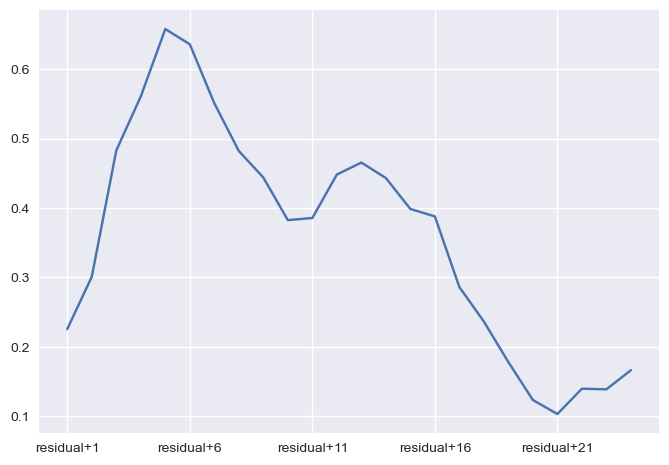

In [403]:
point_row = data_train[64:88]['preds']
point_row.index = simulation_uniform.columns
point_row.plot()

In [404]:
scenarios = simulation_uniform.copy()
# for each row of the simulation add the point forecast
for i in range(simulation_uniform.shape[0]):
    scenarios.iloc[i, :] = simulation_uniform.iloc[i, :] + point_row

<AxesSubplot:>

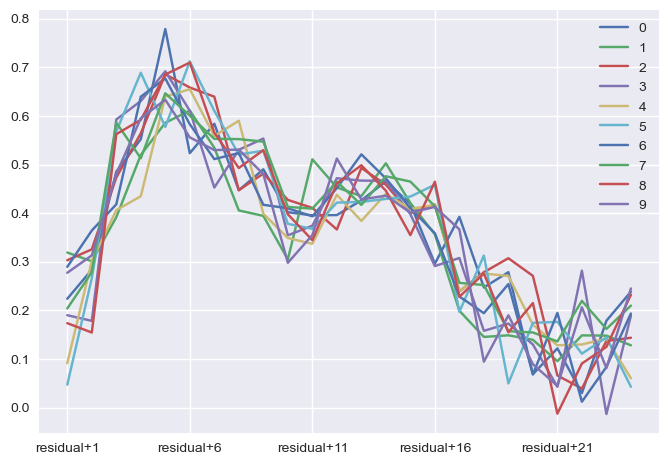

In [405]:
scenarios.T.plot()

In [302]:
data_train[64:68]

,Month,Hour,cons_target,Solar Generation [W/kW],Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],day_year,number,...,net+1,net-23,net_target+1,net_target-23,diffuse_solar_radiation+1,direct_solar_radiation+1,relative_humidity+1,drybulb_temp+1,net_forecast+1,residual
64,8.0,16.0,0.065114,583.025000,21.7,76.0,5.796058,2.944439,87,1,...,-0.956317,-1.007133,0.227070,0.222675,6.102559,5.332719,81.0,20.6,0.290305,0.063236
65,8.0,17.0,0.084100,420.066667,20.6,81.0,6.102559,5.332719,88,1,...,0.890417,-0.318483,0.386792,0.282235,6.082219,6.180017,81.0,20.0,0.403902,0.017111
66,8.0,18.0,0.224518,236.779167,20.0,81.0,6.082219,6.180017,89,1,...,3.944067,1.937817,0.650899,0.477380,5.480639,5.786897,78.0,20.0,0.452432,-0.198466
67,8.0,19.0,0.529241,77.516667,20.0,78.0,5.480639,5.786897,90,1,...,4.272350,1.548717,0.679292,0.443727,3.178054,4.912655,81.0,19.4,0.472881,-0.206411


<AxesSubplot:>

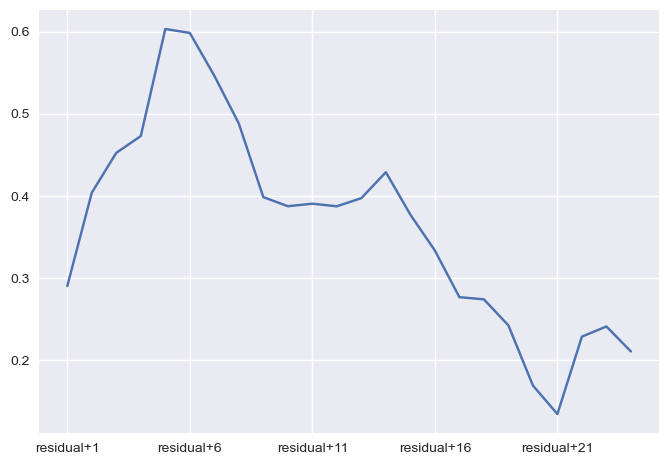

In [301]:
point_row.plot()

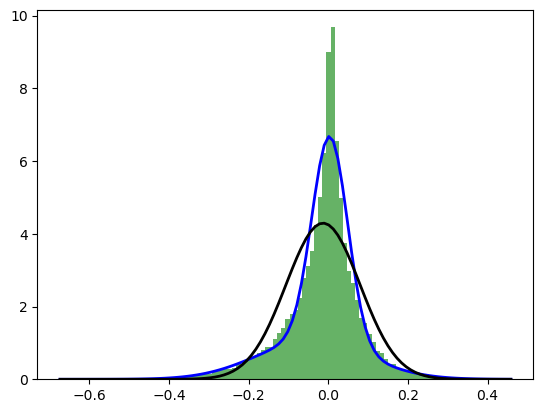

In [28]:
# estimate by a normal distribution
mu, std = norm.fit(data_train['residual'])
# fit to a gaussian mixture model
gmm = GaussianMixture(n_components=2).fit(data_train['residual'].values.reshape(-1, 1))
# plot the histogram and the normal distribution
plt.hist(data_train['residual'], bins=100, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = np.exp(gmm.score_samples(x.reshape(-1,1)))
# plot the PDF
plt.plot(x, y, 'b-', lw=2)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

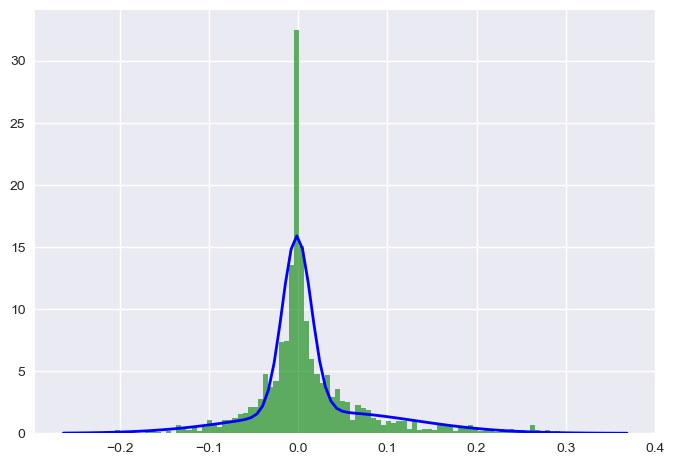

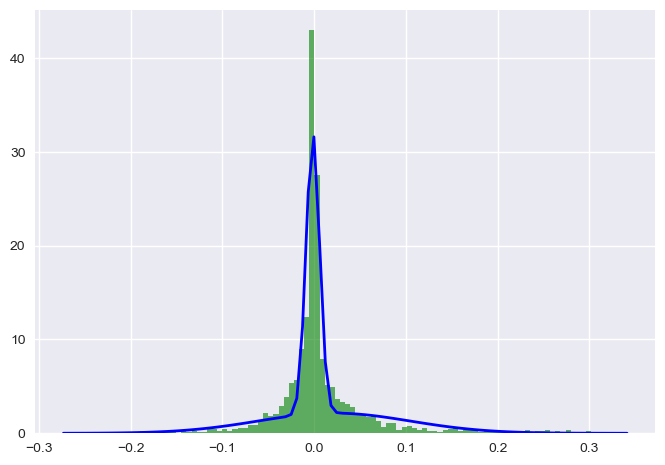

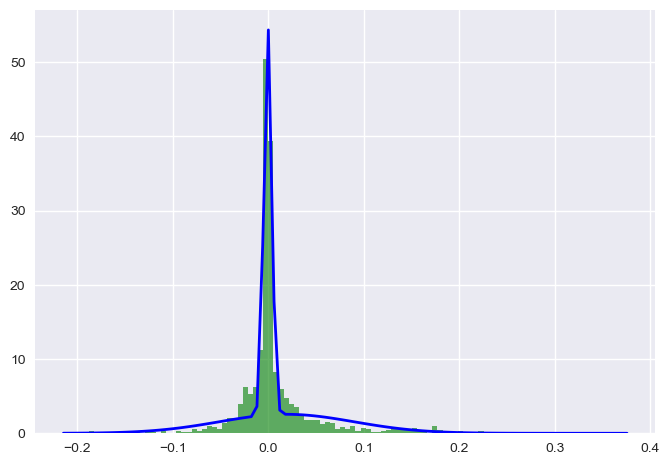

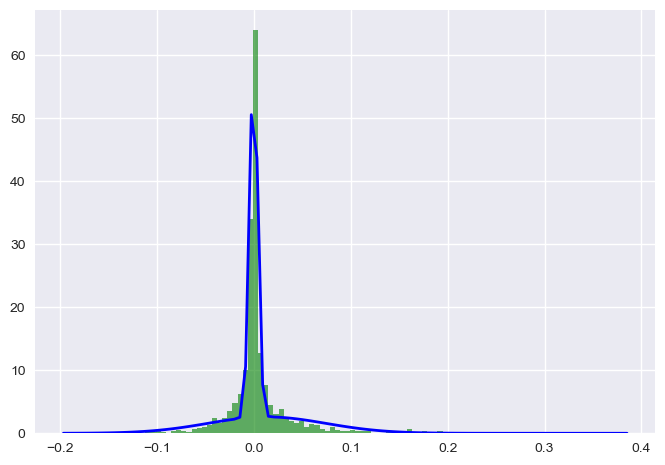

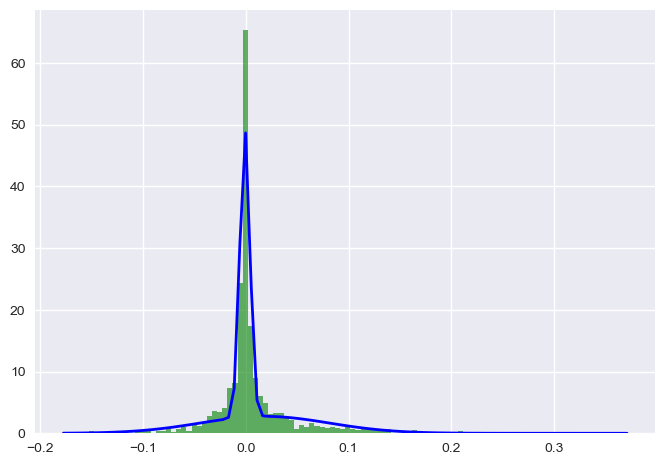

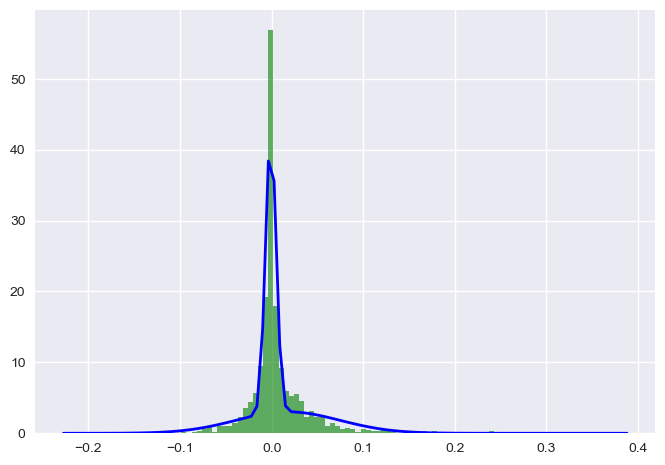

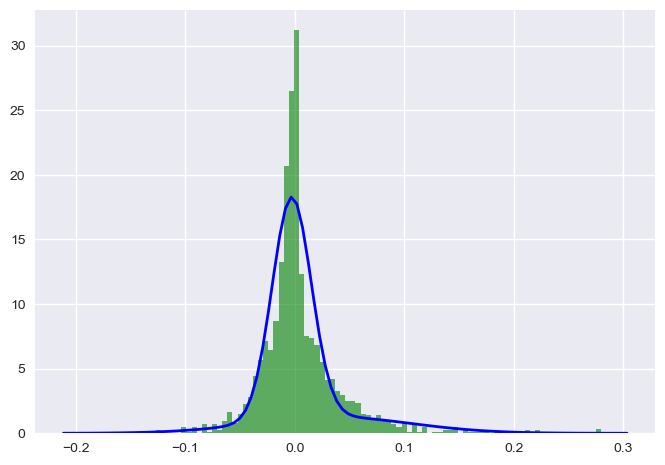

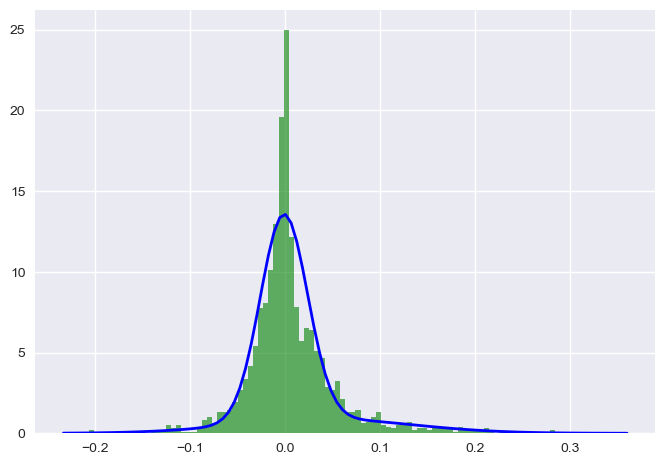

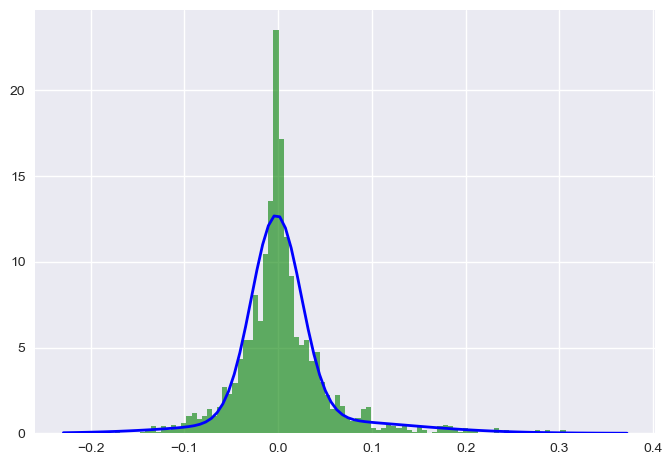

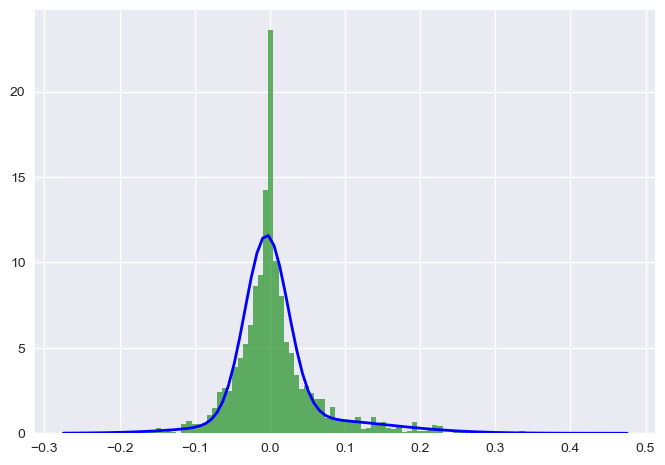

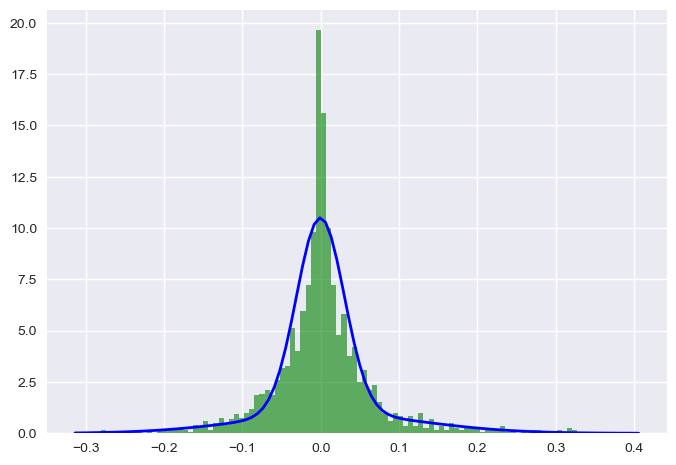

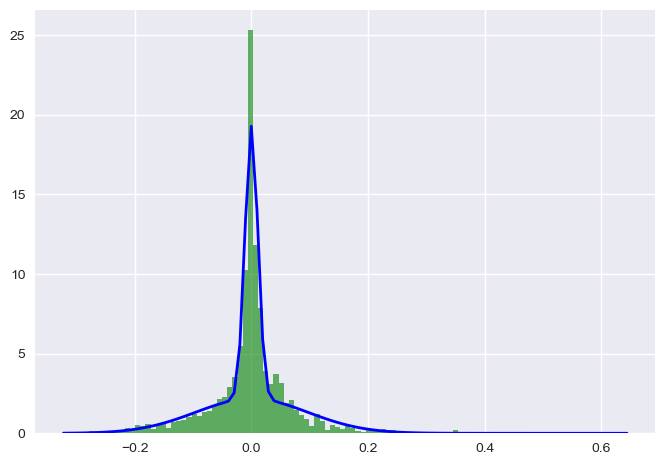

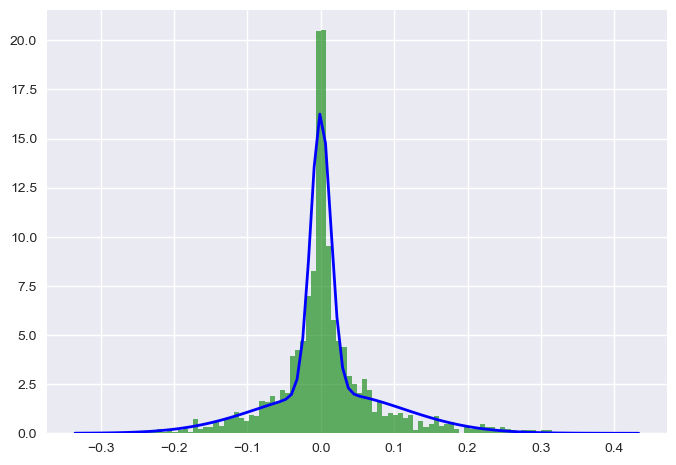

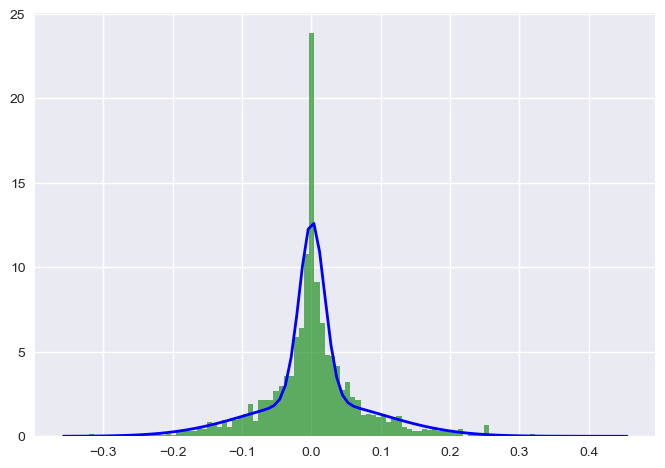

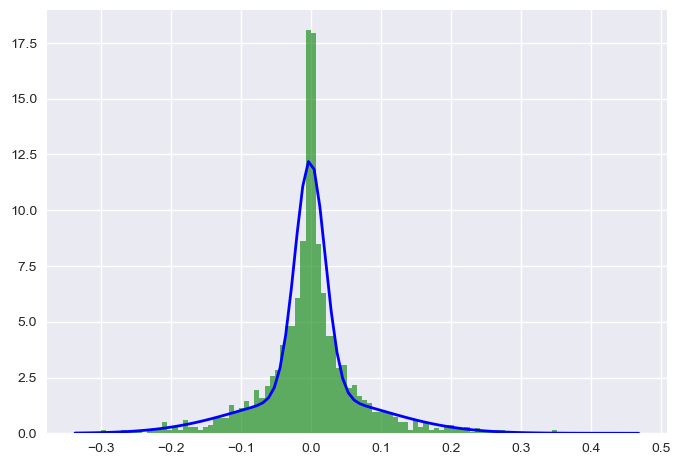

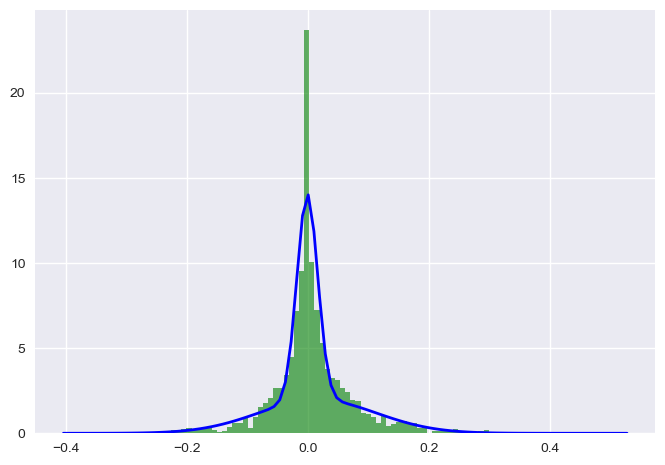

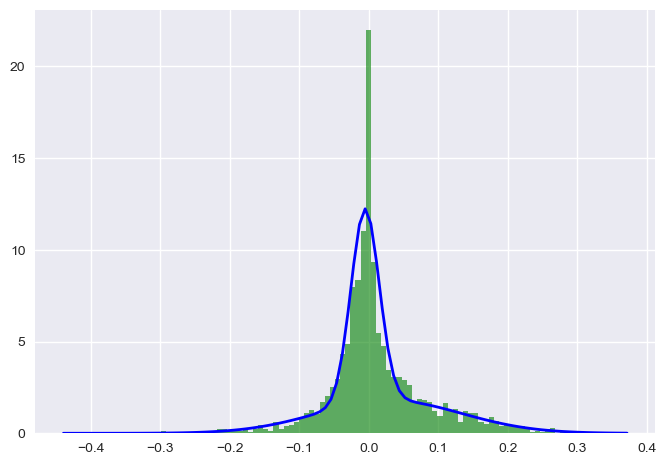

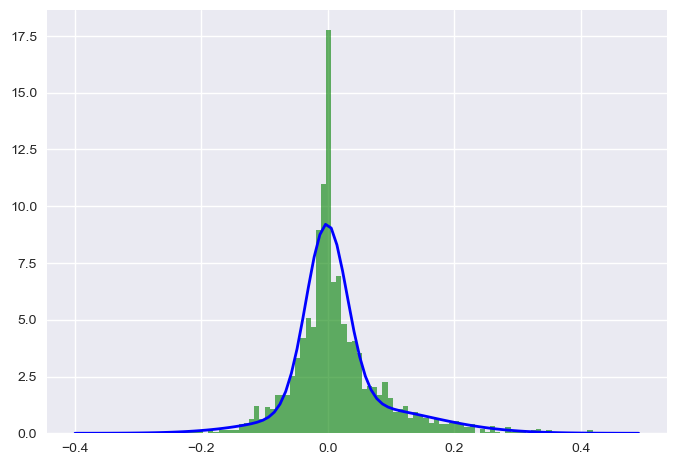

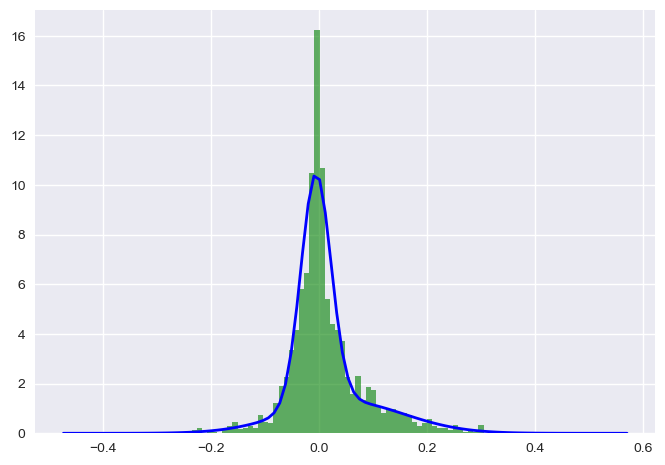

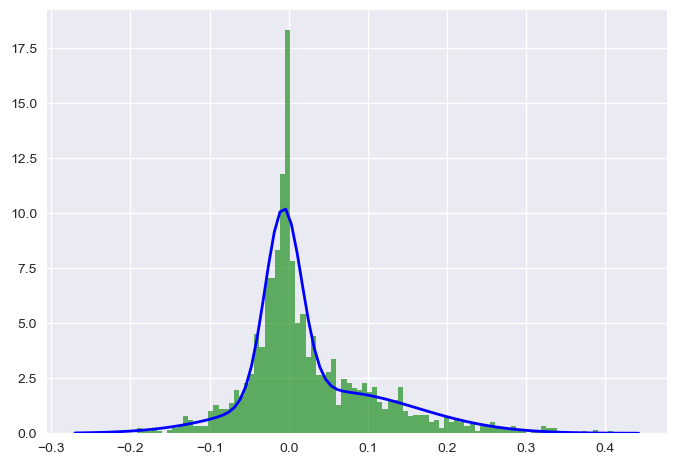

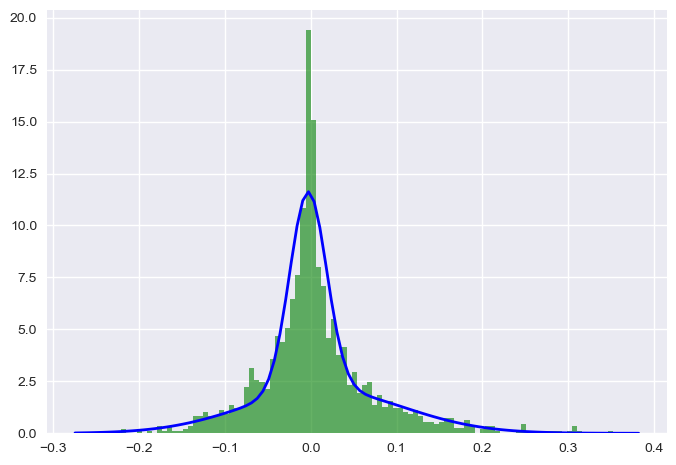

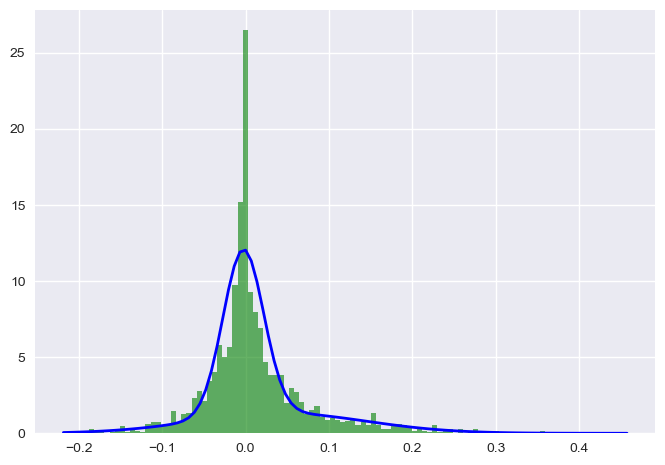

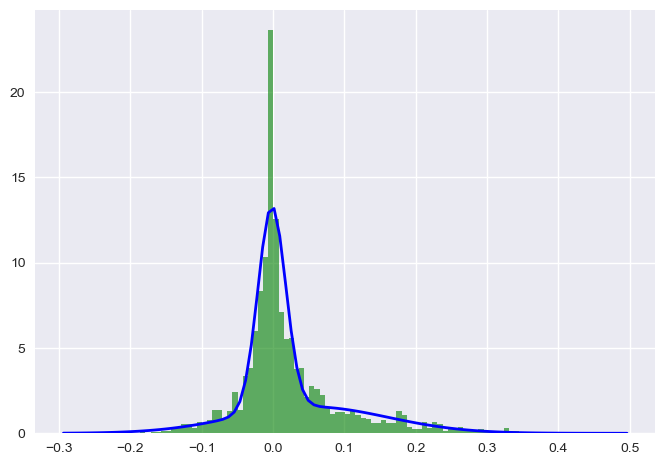

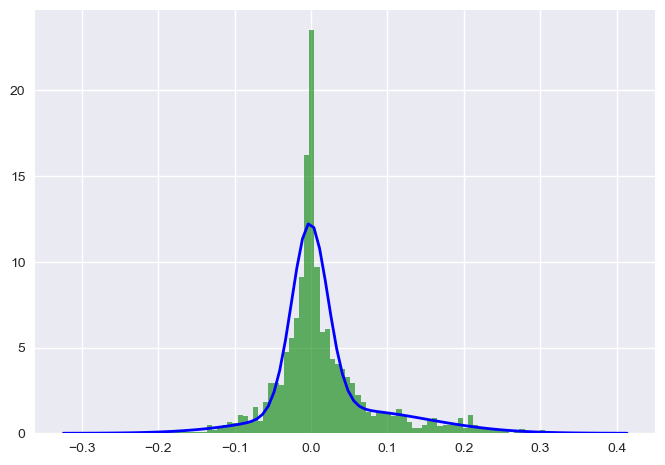

In [418]:
# find gmm for residuals for every Hour
gmm_dict = {}
for hour in data_train['Hour'].unique():
    gmm_dict[hour] = GaussianMixture(n_components=2).fit(data_train.loc[data_train['Hour'] == hour, 'residual'].values.reshape(-1, 1))
    # save the gmm parameters with joblib
    dump(gmm_dict[hour], 'models/gmm/gmm_residual_hour_{}.joblib'.format(int(hour)))
    # plot the histogram and the gmm
    plt.hist(data_train.loc[data_train['Hour'] == hour, 'residual'], bins=100, density=True, alpha=0.6, color='g')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = np.exp(gmm_dict[hour].score_samples(x.reshape(-1,1)))
    # plot the PDF
    plt.plot(x, y, 'b-', lw=2)
    plt.show()

<AxesSubplot:xlabel='Month'>

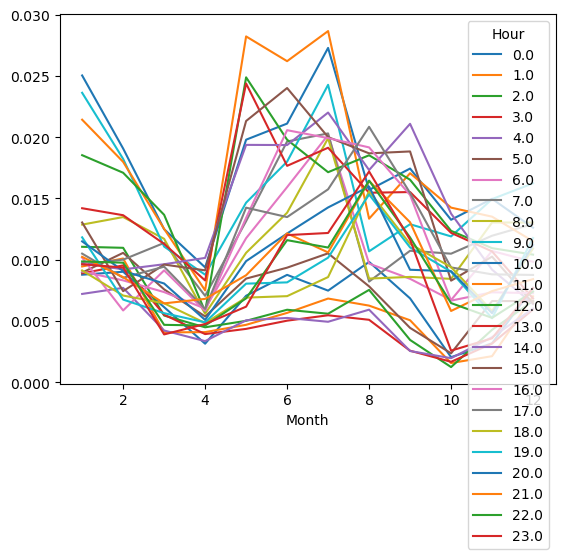

In [5]:
# show variance by hour and month
data_train.groupby(['Month', 'Hour']).var()[target].unstack().plot()

In [11]:
# calculate variance by hour and month
var_df = data_train.groupby(['Month', 'Hour']).var()[target].unstack()
# turn index and column names to int
var_df.index = var_df.index.astype(int)
var_df.columns = var_df.columns.astype(int)
var_df
# save to csv to data folder
var_df.to_csv('data/variance_hour_month.csv')

In [8]:
data_train.groupby(['Month', 'Hour']).var()[target].unstack()

Hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
Month,,,,,,,,,,,,,,,,,,,,,
1.0,0.008780,0.009453,0.011057,0.008894,0.007211,0.008951,0.009030,0.009625,0.012868,0.023625,...,0.009749,0.013043,0.010172,0.010501,0.009127,0.011829,0.011501,0.010236,0.009861,0.009635
2.0,0.009020,0.010102,0.010975,0.009540,0.007707,0.010563,0.008317,0.010008,0.013484,0.018229,...,0.009212,0.007439,0.005861,0.008532,0.007080,0.006751,0.009089,0.008583,0.009761,0.009362
3.0,0.006133,0.004070,0.005447,0.005516,0.004225,0.007584,0.007361,0.011373,0.011708,0.011075,...,0.009634,0.009608,0.009134,0.009434,0.006447,0.005640,0.008062,0.006441,0.004689,0.003908
4.0,0.003149,0.004095,0.004488,0.003935,0.003359,0.005374,0.006013,0.007058,0.005587,0.008783,...,0.010151,0.009136,0.005823,0.005992,0.004837,0.004895,0.005090,0.006808,0.004631,0.004757
5.0,0.007062,0.004691,0.005017,0.004359,0.005061,0.008463,0.011760,0.013148,0.010566,0.014658,...,0.019374,0.021323,0.013415,0.014250,0.006910,0.008050,0.009889,0.008736,0.006849,0.006172
6.0,0.008767,0.005664,0.005921,0.005029,0.005252,0.009354,0.015926,0.019651,0.013838,0.018007,...,0.019360,0.024014,0.020574,0.013483,0.007030,0.008154,0.012141,0.012149,0.011599,0.012011
7.0,0.007481,0.006834,0.005596,0.005469,0.004940,0.010525,0.020187,0.020309,0.019917,0.024276,...,0.022012,0.020010,0.019927,0.015748,0.008588,0.010170,0.014269,0.010597,0.010995,0.012185
8.0,0.009825,0.006257,0.007541,0.005101,0.005927,0.007829,0.009685,0.008221,0.008466,0.010688,...,0.017321,0.018683,0.019169,0.020845,0.015580,0.015326,0.015972,0.016433,0.016456,0.017201
9.0,0.006849,0.005061,0.003456,0.002577,0.002552,0.004440,0.008445,0.010735,0.008599,0.012900,...,0.021093,0.018838,0.015282,0.015449,0.011290,0.011006,0.009183,0.013058,0.011818,0.011635
